In [1]:
import math
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 10})
# PyTorch
import torch
import torchmetrics

In [2]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import models
import utils

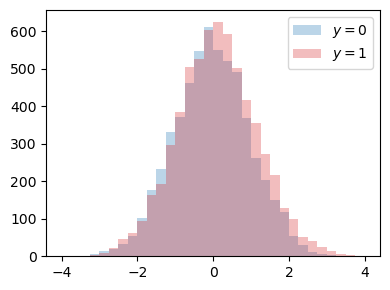

In [3]:
X_train, lengths_train, u_train, y_train = utils.generate_toy_data(400, delta=1.0, deltaS=3, seed=0)
X_val, lengths_val, u_val, y_val = utils.generate_toy_data(100, delta=1.0, deltaS=3, seed=1)
X_test, lengths_test, u_test, y_test = utils.generate_toy_data(1000, delta=1.0, deltaS=3, seed=2)

X_y0 = torch.cat([X_i for i, X_i in enumerate(torch.split(X_train, lengths_train)) if y_train[i] == 0])
X_y1 = torch.cat([X_i for i, X_i in enumerate(torch.split(X_train, lengths_train)) if y_train[i] == 1])

def get_bins(data, width=0.25):
    min_val, max_val = torch.floor(data.min()), torch.ceil(data.max())
    return torch.arange(min_val, max_val + width, width)

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.hist(X_y0[:,0], alpha=0.3, bins=get_bins(X_y0[:,0]), color="#1F77B4", label=r"$y=0$")
ax.hist(X_y1[:,0], alpha=0.3, bins=get_bins(X_y1[:,0]), color="#D62728", label=r"$y=1$")
ax.legend()

fig.tight_layout()
plt.show()

In [4]:
deltas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
bayes_aurocs = []

for delta in deltas:

    X_train, lengths_train, u_train, y_train = utils.generate_toy_data(400, delta=delta, deltaS=3, seed=0)
    X_val, lengths_val, u_val, y_val = utils.generate_toy_data(100, delta=delta, deltaS=3, seed=1)
    X_test, lengths_test, u_test, y_test = utils.generate_toy_data(100, delta=delta, deltaS=3, seed=2)

    auroc = torchmetrics.AUROC(task="binary")

    bayes_proba = torch.stack([utils.proba_y1_given_h(X_i[:,0], delta, deltaS=3) for X_i in torch.split(X_test, lengths_test)])
    bayes_aurocs.append(auroc(bayes_proba, y_test).item())

print(bayes_aurocs)

[0.5717238187789917, 0.7118644714355469, 0.8305084109306335, 0.9218685030937195, 0.977263331413269, 0.9971061944961548, 0.9999999403953552, 0.9999999403953552, 0.9999999403953552, 1.0]


In [5]:
def max_logits(X, lengths, delta):
    
    model = models.ClfPool(in_features=768, out_features=1, instance_conv=False, pooling="max", use_pos_embedding=False)

    state_dict = {
        "clf.weight": torch.zeros(1, 768),
        "clf.bias": torch.zeros(1),
    }

    state_dict["clf.weight"][0,0] = 1.0
    state_dict["clf.bias"][0] = -delta/2

    model.load_state_dict(state_dict)
    
    logits, attention_weights = model(X, lengths)
    
    return logits

def mean_logits(X, lengths, delta):
    
    model = models.ClfPool(in_features=768, out_features=1, instance_conv=False, pooling="mean", use_pos_embedding=False)

    state_dict = {
        "clf.weight": torch.zeros(1, 768),
        "clf.bias": torch.zeros(1),
    }

    state_dict["clf.weight"][0,0] = 1.0
    state_dict["clf.bias"][0] = -delta/2

    model.load_state_dict(state_dict)
    
    logits, attention_weights = model(X, lengths)
    
    return logits

def attention_logits(X, lengths, delta):
    
    model = models.ClfPool(in_features=768, out_features=1, instance_conv=False, pooling="attention", use_pos_embedding=False)
    
    state_dict = {
        "clf.weight": torch.zeros(1, 768),
        "clf.bias": torch.zeros(1),
        "pool.mlp.0.weight": torch.zeros(128, 1),
        "pool.mlp.0.bias": torch.zeros(128),
        "pool.mlp.2.weight": torch.zeros(1, 128),
        "pool.mlp.2.bias": torch.zeros(1),
    }

    state_dict["clf.weight"][0,0] = 1.0
    state_dict["clf.bias"][0] = -delta/2
    state_dict["pool.mlp.0.weight"][0,0] = 0.01
    state_dict["pool.mlp.2.weight"][0,0] = 100.0

    model.load_state_dict(state_dict)

    logits, attention_weights = model(X, lengths)
    
    return logits

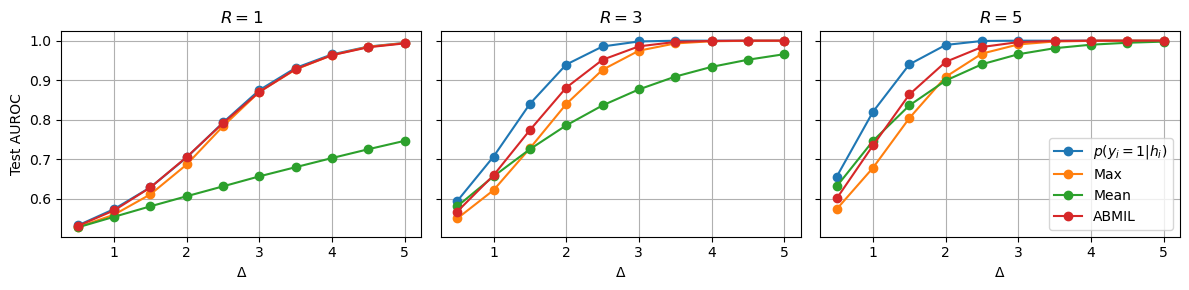

In [6]:
with torch.no_grad():
    
    ncols, nrows = 3, 1
    fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharey=True)
    
    seperations = [1, 3, 5]
    
    for i, seperation in enumerate(seperations):
        
        deltas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
        bayes_aurocs, max_aurocs, mean_aurocs, attention_aurocs = [], [], [], []
    
        for delta in deltas:
        
            X_train, lengths_train, u_train, y_train = utils.generate_toy_data(400, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=0)
            X_val, lengths_val, u_val, y_val = utils.generate_toy_data(100, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=1)
            X_test, lengths_test, u_test, y_test = utils.generate_toy_data(1000, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=2)
        
            auroc = torchmetrics.AUROC(task="binary")
        
            # Bayes estimator
            bayes_proba = torch.stack([utils.proba_y1_given_h(X_i[:,0], delta, deltaS=seperation) for X_i in torch.split(X_test, lengths_test)])
            bayes_aurocs.append(auroc(bayes_proba, y_test).item())
        
            # Max pooling
            logits = max_logits(X_test, lengths_test, delta)
            max_aurocs.append(auroc(logits, y_test).item())
            
            # Mean pooling
            logits = mean_logits(X_test, lengths_test, delta)
            mean_aurocs.append(auroc(logits, y_test).item())
            
            # Attention-based pooling
            logits = attention_logits(X_test, lengths_test, delta)
            attention_aurocs.append(auroc(logits, y_test).item())
            
        axs[i].plot(deltas, bayes_aurocs, color="#1F77B4", label=r"$p(y_i=1 \mid h_i)$", marker="o")
        axs[i].plot(deltas, max_aurocs, color="#FF7F0E", label="Max", marker="o")
        axs[i].plot(deltas, mean_aurocs, color="#2CA02C", label="Mean", marker="o")
        axs[i].plot(deltas, attention_aurocs, color="#D62728", label="ABMIL", marker="o")
        axs[i].set_xlabel(r"$\Delta$")
        axs[i].grid()
        
    axs[0].set_title(r"$R=1$")
    axs[0].set_ylabel("Test AUROC")
    
    axs[1].set_title(r"$R=3$")
    
    axs[2].set_title(r"$R=5$")
    axs[2].legend(loc="lower right")

    fig.tight_layout()
    fig.savefig("handcrafted_parameters1.pdf", bbox_inches="tight")
    plt.show()

In [7]:
def instance_logits(X, lengths, delta, kernel_size):
    
    model = models.ClfPool(in_features=768, out_features=1, instance_conv=True, kernel_size=kernel_size, pooling="attention", use_pos_embedding=False)
        
    state_dict = {
        "clf.weight": torch.zeros(1, 768),
        "clf.bias": torch.zeros(1),
        "conv.conv.weight": torch.zeros(1, 1, kernel_size),
        "conv.conv.bias": torch.zeros(1),
        "pool.mlp.0.weight": torch.zeros(128, 1),
        "pool.mlp.0.bias": torch.zeros(128),
        "pool.mlp.2.weight": torch.zeros(1, 128),
        "pool.mlp.2.bias": torch.zeros(1),
    }    
    
    state_dict["clf.weight"][0,0] = 1.0
    state_dict["clf.bias"][0] = -delta/2
    state_dict["conv.conv.weight"][0,0,:] = 1.0
    state_dict["pool.mlp.0.weight"][0,0] = 0.01
    state_dict["pool.mlp.2.weight"][0,0] = 100.0

    model.load_state_dict(state_dict)
    
    logits, attention_weights = model(X, lengths)
    
    return logits

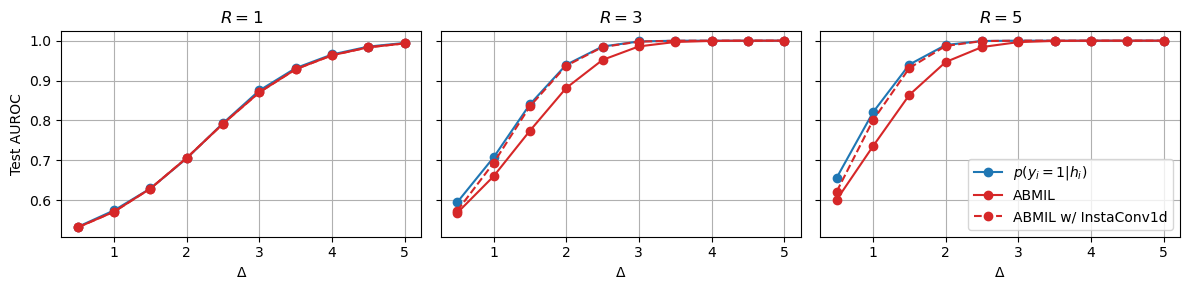

In [8]:
with torch.no_grad():
    
    ncols, nrows = 3, 1
    fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharey=True)
    
    seperations = [1, 3, 5]
    
    for i, seperation in enumerate(seperations):
        
        deltas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
        bayes_aurocs, attention_aurocs, instance_aurocs = [], [], []
    
        for delta in deltas:
        
            X_train, lengths_train, u_train, y_train = utils.generate_toy_data(400, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=0)
            X_val, lengths_val, u_val, y_val = utils.generate_toy_data(100, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=1)
            X_test, lengths_test, u_test, y_test = utils.generate_toy_data(1000, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=2)
        
            auroc = torchmetrics.AUROC(task="binary")
        
            # Bayes estimator
            bayes_proba = torch.stack([utils.proba_y1_given_h(X_i[:,0], delta, deltaS=seperation) for X_i in torch.split(X_test, lengths_test)])
            bayes_aurocs.append(auroc(bayes_proba, y_test).item())
                    
            # Attention-based pooling
            logits = attention_logits(X_test, lengths_test, delta)
            attention_aurocs.append(auroc(logits, y_test).item())
            
            # Attention-based pooling
            logits = instance_logits(X_test, lengths_test, delta, seperation)
            instance_aurocs.append(auroc(logits, y_test).item())
            
        axs[i].plot(deltas, bayes_aurocs, color="#1F77B4", label=r"$p(y_i=1 \mid h_i)$", marker="o")
        axs[i].plot(deltas, attention_aurocs, color="#D62728", label="ABMIL", marker="o")
        axs[i].plot(deltas, instance_aurocs, color="#D62728", label="ABMIL w/ InstaConv1d", linestyle='--', marker="o")
        axs[i].set_xlabel(r"$\Delta$")
        axs[i].grid()
        
    axs[0].set_title(r"$R=1$")
    axs[0].set_ylabel("Test AUROC")
    
    axs[1].set_title(r"$R=3$")
    
    axs[2].set_title(r"$R=5$")
    axs[2].legend(loc="lower right")

    fig.tight_layout()
    fig.savefig("handcrafted_parameters2.pdf", bbox_inches="tight")
    plt.show()

In [9]:
def transformer_logits(X, lengths, delta, seperation):
    
    embed_dim = 768
    model = models.PoolClf(in_features=embed_dim, out_features=1, pooling="transformer", use_pos_embedding=False)
    
    state_dict = {
        "pool.cls_token": torch.zeros(1, embed_dim),
        "pool.layer1.norm.weight": torch.zeros(embed_dim),
        "pool.layer1.norm.bias": torch.zeros(embed_dim),
        "pool.layer1.attn.in_proj_weight": torch.zeros(3 * embed_dim, embed_dim),
        "pool.layer1.attn.in_proj_bias": torch.zeros(3 * embed_dim),
        "pool.layer1.attn.out_proj.weight": torch.zeros(embed_dim, embed_dim),
        "pool.layer1.attn.out_proj.bias": torch.zeros(embed_dim),
        "pool.position_layer.proj1.weight": torch.zeros(embed_dim, 1, 3),
        "pool.position_layer.proj1.bias": torch.zeros(embed_dim),
        "pool.position_layer.proj2.weight": torch.zeros(embed_dim, 1, 5),
        "pool.position_layer.proj2.bias": torch.zeros(embed_dim),
        "pool.position_layer.proj3.weight": torch.zeros(embed_dim, 1, 7),
        "pool.position_layer.proj3.bias": torch.zeros(embed_dim),
        "pool.layer2.norm.weight": torch.zeros(embed_dim),
        "pool.layer2.norm.bias": torch.zeros(embed_dim),
        "pool.layer2.attn.in_proj_weight": torch.zeros(3 * embed_dim, embed_dim),
        "pool.layer2.attn.in_proj_bias": torch.zeros(3 * embed_dim),
        "pool.layer2.attn.out_proj.weight": torch.zeros(embed_dim, embed_dim),
        "pool.layer2.attn.out_proj.bias": torch.zeros(embed_dim),
        "clf.weight": torch.zeros(1, embed_dim),
        "clf.bias": torch.zeros(1),
    }
    
    eye = torch.eye(embed_dim)
    state_dict["pool.cls_token"][0,0] = -100.0
    if seperation == 1:
        state_dict["pool.position_layer.proj1.bias"][0] = torch.tensor([1*(-delta/2)])
    elif seperation == 3:
        state_dict["pool.position_layer.proj1.weight"][0,0,:] = torch.tensor([1.0, 0.0, 1.0])
        state_dict["pool.position_layer.proj1.bias"][0] = torch.tensor([3*(-delta/2)])
    elif seperation == 5:
        state_dict["pool.position_layer.proj2.weight"][0,0,:] = torch.tensor([1.0, 1.0, 0.0, 1.0, 1.0])
        state_dict["pool.position_layer.proj2.bias"][0] = torch.tensor([5*(-delta/2)])
    state_dict["pool.layer2.norm.weight"][0] = 1.0
    state_dict["pool.layer2.attn.in_proj_weight"] = torch.cat((-0.01*math.sqrt(embed_dim)*eye, eye, eye))
    state_dict["pool.layer2.attn.out_proj.weight"] = eye
    #matrix = torch.zeros(embed_dim, embed_dim)
    #matrix[:,0] = 1.0
    #linspace = torch.linspace(start=0.0, end=seperation, steps=768)    #state_dict["pool.layer2.attn.in_proj_weight"] = torch.cat((-0.01*math.sqrt(embed_dim)*matrix, matrix, matrix))
    #state_dict["pool.layer2.attn.in_proj_bias"] = torch.cat((-linspace, -linspace, -linspace))
    #state_dict["pool.layer2.attn.out_proj.weight"] = (1/768**2)*torch.ones(embed_dim, embed_dim)
    state_dict["pool.layer2.attn.out_proj.bias"][0] = 100.0
    state_dict["clf.weight"][0,:] = 1.0
    #state_dict["clf.bias"][0] = -delta/2
    
    model.load_state_dict(state_dict)
    
    logits, attention_weights = model(X, lengths)
    
    return logits

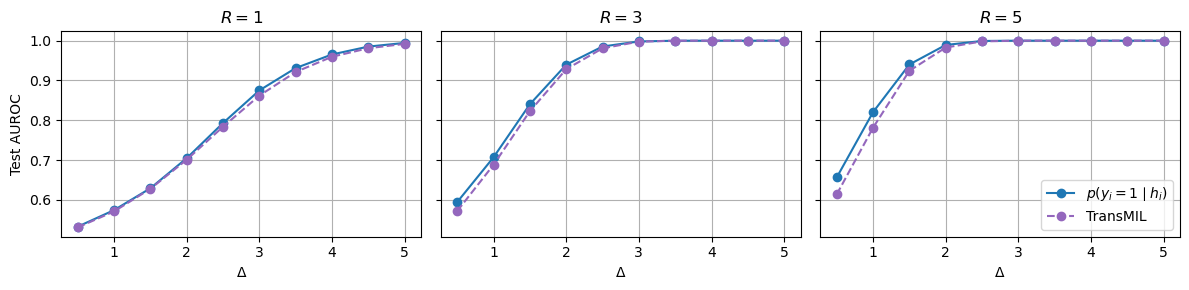

In [10]:
with torch.no_grad():
    
    ncols, nrows = 3, 1
    fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharey=True)
    
    seperations = [1, 3, 5]
    
    for i, seperation in enumerate(seperations):
        
        deltas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
        bayes_aurocs, transformer_aurocs, without_aurocs = [], [], []
    
        for delta in deltas:
        
            X_train, lengths_train, u_train, y_train = utils.generate_toy_data(400, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=0)
            X_val, lengths_val, u_val, y_val = utils.generate_toy_data(100, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=1)
            X_test, lengths_test, u_test, y_test = utils.generate_toy_data(1000, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=2)
        
            auroc = torchmetrics.AUROC(task="binary")
        
            # Bayes estimator
            bayes_proba = torch.stack([utils.proba_y1_given_h(X_i[:,0], delta, deltaS=seperation) for X_i in torch.split(X_test, lengths_test)])
            bayes_aurocs.append(auroc(bayes_proba, y_test).item())
                    
            # TransMIL
            logits = transformer_logits(X_test, lengths_test, delta, seperation)
            transformer_aurocs.append(auroc(logits, y_test).item())
            
            # TransMIL w/o positional encoding
            #positional_encoding = torch.cat([torch.arange(0, length+1)[1:] / length+1 for length in lengths_test])  
            #logits = transformer_logits(X_test - positional_encoding[:,None], lengths_test, delta, seperation)
            #without_aurocs.append(auroc(logits, y_test).item())
            
        axs[i].plot(deltas, bayes_aurocs, color="#1F77B4", label=r"$p(y_i=1 \mid h_i)$", marker="o")
        axs[i].plot(deltas, transformer_aurocs, color="#9467BD", label="TransMIL", linestyle='--', marker="o")
        axs[i].set_xlabel(r"$\Delta$")
        axs[i].grid()
        
    axs[0].set_title(r"$R=1$")
    axs[0].set_ylabel("Test AUROC")
    
    axs[1].set_title(r"$R=3$")
    
    axs[2].set_title(r"$R=5$")
    axs[2].legend(loc="lower right")

    fig.tight_layout()
    fig.savefig("handcrafted_parameters3.pdf", bbox_inches="tight")
    plt.show()

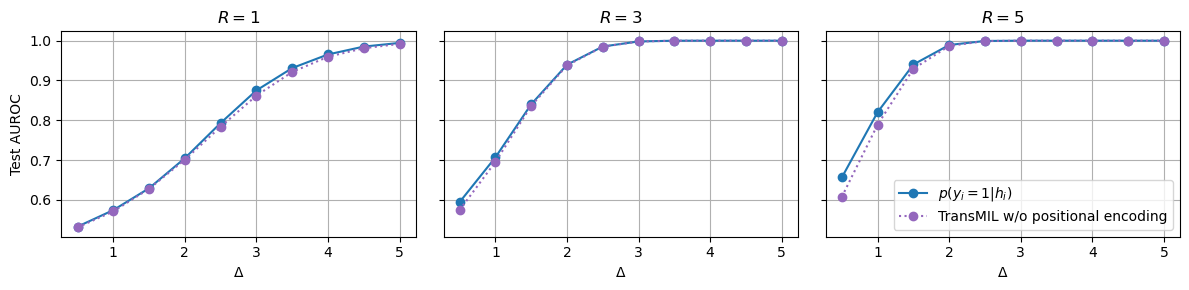

In [11]:
with torch.no_grad():
    
    ncols, nrows = 3, 1
    fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharey=True)
    
    seperations = [1, 3, 5]
    
    for i, seperation in enumerate(seperations):
        
        deltas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
        bayes_aurocs, transformer_aurocs, without_aurocs = [], [], []
    
        for delta in deltas:
        
            X_train, lengths_train, u_train, y_train = utils.generate_toy_data(400, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=0)
            X_val, lengths_val, u_val, y_val = utils.generate_toy_data(100, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=1)
            X_test, lengths_test, u_test, y_test = utils.generate_toy_data(1000, delta=delta, S_low=15, S_high=46, deltaS=seperation, seed=2)
        
            auroc = torchmetrics.AUROC(task="binary")
        
            # Bayes estimator
            bayes_proba = torch.stack([utils.proba_y1_given_h(X_i[:,0], delta, deltaS=seperation) for X_i in torch.split(X_test, lengths_test)])
            bayes_aurocs.append(auroc(bayes_proba, y_test).item())
                    
            # TransMIL
            #logits = transformer_logits(X_test, lengths_test, delta, seperation)
            #transformer_aurocs.append(auroc(logits, y_test).item())
            
            # TransMIL w/o positional encoding
            positional_encoding = torch.cat([torch.arange(0, length+1)[1:] / length+1 for length in lengths_test])  
            logits = transformer_logits(X_test - positional_encoding[:,None], lengths_test, delta, seperation)
            without_aurocs.append(auroc(logits, y_test).item())
            
        axs[i].plot(deltas, bayes_aurocs, color="#1F77B4", label=r"$p(y_i=1 \mid h_i)$", marker="o")
        #axs[i].plot(deltas, transformer_aurocs, color="#9467BD", label="TransMIL", linestyle='--', marker="o")
        axs[i].plot(deltas, without_aurocs, color="#9467BD", label="TransMIL w/o positional encoding", linestyle=':', marker="o")
        axs[i].set_xlabel(r"$\Delta$")
        axs[i].grid()
        
    axs[0].set_title(r"$R=1$")
    axs[0].set_ylabel("Test AUROC")
    
    axs[1].set_title(r"$R=3$")
    
    axs[2].set_title(r"$R=5$")
    axs[2].legend(loc="lower right")

    fig.tight_layout()
    fig.savefig("handcrafted_parameters4.pdf", bbox_inches="tight")
    plt.show()